In [2]:
# IMPORTS
using FFTW, Plots
using DSP: unwrap

In [3]:
# CONSTANTS
c = 299792458

# Waveguide
β2 = -2.168e-26
L = 5_000
α = 0*0.046e-3
γ = 1.1e-3
λc = 1.55e-6 
ω0 = 2π*c/λc
# Signal 
T = 200e-12 # Duration
N = 2^13 # Time samples
Ns = 1 # Soliton number
Δτ =5e-12 # FWHM
τ = Δτ/1.7627
P = abs(β2)/(γ*τ^2)
# Vectors 
βs = [0.0, β2]
t = T*(-N÷2:N÷2-1)/N;
ν = fftshift((-N÷2:N÷2-1)./T);
ω = 2π.*ν;

u0 = sqrt(P)*sech.(t ./ τ);

In [15]:
NL1(u) = 1.0im .* γ * (fft(u .* abs2.(u)))

function NL2(u)
	IT = u .* abs2.(u)
	1.0im .* γ * fft(IT .- ifft(ω .* fft(IT)) ./ ω0)
end


function _compute_error(a, b) # MSD
	sqrt(sum(abs2.(a .- b)) ./ sum(abs2.(a)))
end


# Simulation parameters 
NL = NL1
dz = 0.1  # in percent 
reltol = 1e-6
zk = 0
k5 = nothing
zs = []
ϵ_hist = []
u = ComplexF64.(u0)
U = fft(u)
NU = NL(u)
D = -0.5α .+ 1im*sum([ (βs[i]/factorial(i)) .*ω.^i for i in eachindex(βs) ]);


while zk < L

	e = exp.(0.5 * dz * D)
	Uip = e .* U
	k1 = e .* NU
#= 	if isnothing(k5)
		k1 = e .* ifft(U)
	else
		k1 = D .* k5
	end =#

	k2 = NL(ifft(Uip .+ 0.5 * dz * k1))

	k3 = NL(ifft(Uip .+ 0.5 * dz * k2))

	k4 = NL(ifft(e .* (Uip .+ dz * k3)))

	r = e .* (Uip .+ dz * (k1 / 6.0 .+ k2 / 3.0 .+ k3 / 3.0))

	U1 = r .+ dz * k4 / 6.0

	k5 = NL(ifft(U1))

	U2 = r .+ dz * (k4 / 15.0 .+ k5 / 10.0)

	err = _compute_error(U1, U2)

	if !(err < 1.0)
	print(err)
	break
	end
	
	dzopt = max(0.5, min(2.0, 0.9 * sqrt(sqrt(reltol / err)))) * dz

	if err <= reltol

		zk = zk + dz
		dz = min(dzopt, L - zk)
		append!(ϵ_hist, err)
		U = U1
		NU = k5

	else
		dz = dzopt
	end
end

sol = ifft(U)


8192-element Vector{ComplexF64}:
 -2.0711622261693208e-7 + 1.5813313380963478e-7im
  -2.072655495011233e-7 + 1.5817660414807477e-7im
 -2.0771151065801519e-7 + 1.5830617106082912e-7im
 -2.0844806414288541e-7 + 1.5851931667310026e-7im
  -2.094652199469138e-7 + 1.588118744288991e-7im
 -2.1074914424712432e-7 + 1.5917808193766092e-7im
 -2.1228231994463442e-7 + 1.5961064592229235e-7im
  -2.140437365127923e-7 + 1.6010082853901153e-7im
  -2.160091273628595e-7 + 1.6063855173831243e-7im
 -2.1815123718571527e-7 + 1.61212511118336e-7im
                        ⋮
 -2.1815123724122643e-7 + 1.61212511118336e-7im
  -2.160091274738818e-7 + 1.60638551766068e-7im
 -2.1404373645728114e-7 + 1.6010082862227826e-7im
 -2.1228231988912327e-7 + 1.5961064581127005e-7im
 -2.1074914424712432e-7 + 1.591780819654165e-7im
 -2.0946521989140265e-7 + 1.5881187462318813e-7im
  -2.084480640318631e-7 + 1.5851931678412257e-7im
  -2.077115107690375e-7 + 1.583061710885847e-7im
 -2.0726554955663445e-7 + 1.5817660420358592e-7im

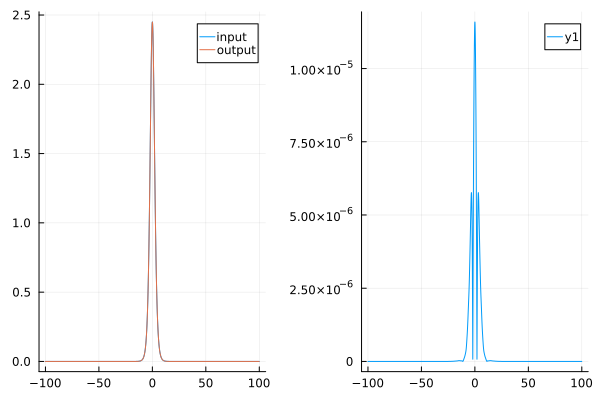

In [16]:
p1 = plot();
plot!(p1,t*1e12, abs2.(u0), label="input");
plot!(p1,t*1e12, abs2.(sol), label="output");

p2 = plot()
plot!(p2,t*1e12, (abs.(abs2.(u0).-abs2.(sol))))

plot(p1,p2)

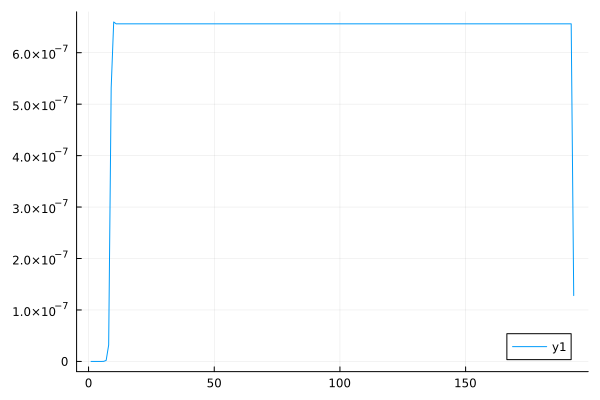

In [14]:
plot(ϵ_hist)

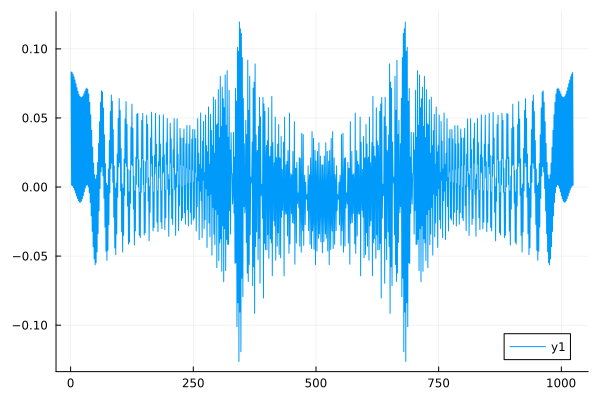

In [108]:
plot(unwrap(angle.(sol)))

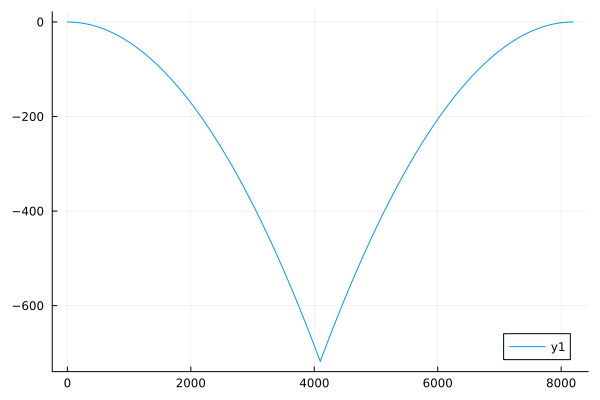

In [13]:
plot(imag.(D))